In [2]:
import numpy as np
!pip install matplotlib
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
t = np.linspace(0,999,1000).reshape(-1,1)
u = np.sin(2*np.pi*t/250)
y = np.zeros_like(t)
for i in range(2,1000):
    y[i] = y[i-1]/(1+y[i-2])+u[i-1]**3

X = np.concatenate([y[1:999], y[0:998], u[1:999]], axis=1)
y = y[2:]

In [4]:
X_train = X[:700]
y_train = y[:700]
X_test = X[700:]
y_test = y[700:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 3), (700, 1), (298, 3), (298, 1))

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
def gussianRBF(x ,center = (0,0), spread = 1):
    x = np.array(x)
    center = np.atleast_2d(center)
    return np.exp(-np.sum(((x-center)**2), axis=1)/spread**2)

In [7]:
gussianRBF([1,1],(1,1))

array([1.])

In [8]:
def mean_distance_centers(centers):
    n_centers = len(centers)
    distances = []
    for i in range(n_centers):
        for j in range(i+1,n_centers):
            distances.append(np.linalg.norm(centers[i]-centers[j]))

    return np.mean(distances)

In [9]:
class RBF:
    def __init__(self, n_center=10, spread = -1):
        self.n_center = n_center
        self.spread = spread

    def fit(self, X, y):
        self.centers = np.random.choice(X.shape[0], self.n_center, replace=False)
        self.centers = X[self.centers]

        if self.spread == -1:
            self.spread = mean_distance_centers(self.centers)
        Phi = np.empty((X.shape[0],self.n_center))
        for i, center in enumerate(self.centers):
            g = gussianRBF(X, center, self.spread)
            Phi[:,i] = g

        w = np.linalg.pinv(Phi) @ y
        self.w = w

    def __call__(self, X):
        Phi = np.empty((X.shape[0],self.n_center))
        for i, center in enumerate(self.centers):
            g = gussianRBF(X, center, self.spread)
            Phi[:,i] = g

        y = Phi@self.w
        return y

In [10]:
model = RBF(100)
model.fit(X_train, y_train)

In [11]:
y_pred_train = model(X_train)
y_pred_test = model(X_test)

In [12]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [13]:
print('Root mean square error for train:',RMSE(y_train, y_pred_train))
print('Root mean square error for test:',RMSE(y_test, y_pred_test))

Root mean square error for train: 3.1322178192467454
Root mean square error for test: 4.244071448906399


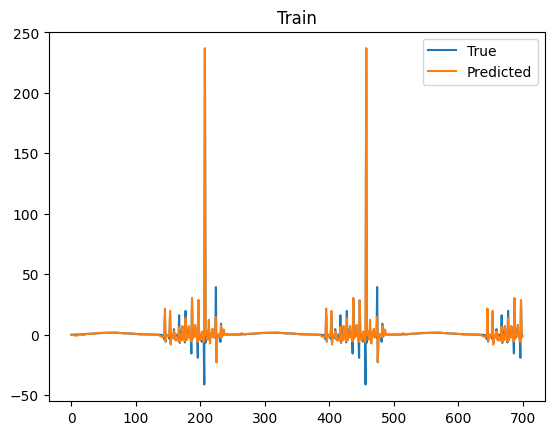

In [14]:
plt.plot(y_train, label = 'True')
plt.plot(y_pred_train, label = 'Predicted')
plt.title('Train')
plt.legend()
plt.show()

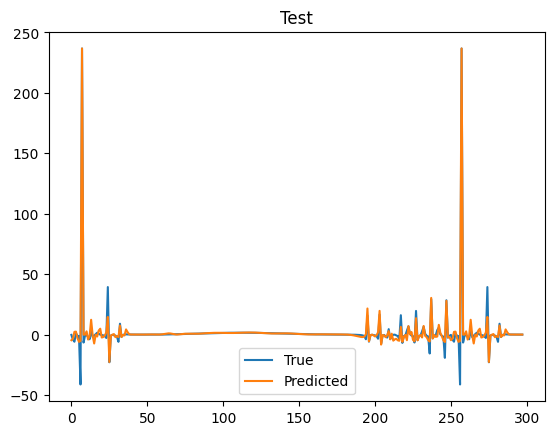

In [15]:
plt.plot(y_test, label = 'True')
plt.plot(y_pred_test, label = 'Predicted')
plt.title('Test')
plt.legend()
plt.show()

In [16]:
K = [10, 20, 50, 100, 200]
RMSE_test = []
for k in K:
    model = RBF(k,5)
    model.fit(X_train, y_train)

    y_pred_test = model(X_test)
    RMSE_test.append(RMSE(y_test, y_pred_test))

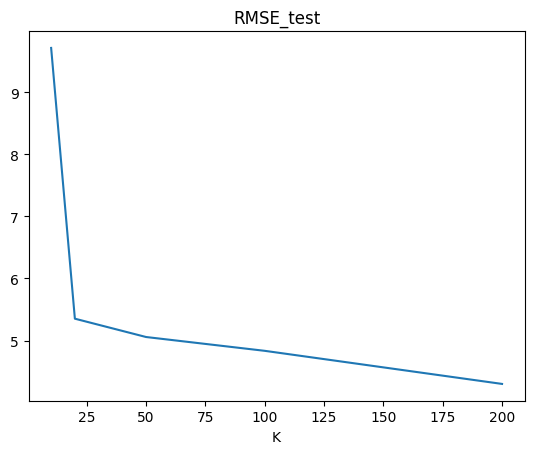

Min of RMSE_test: 4.300742583021355 for k = 200


In [17]:
plt.plot(K, RMSE_test)
plt.title('RMSE_test')
plt.xlabel('K')
plt.show()
print('Min of RMSE_test:', np.min(RMSE_test), 'for k =', K[np.argmin(RMSE_test)])

In [18]:
k = 200
spread = [0.5, 1, 5, 7, 10]
RMSE_test = []

for sp in spread:
    model = RBF(k,sp)
    model.fit(X_train, y_train)

    y_pred_test = model(X_test)
    RMSE_test.append(RMSE(y_train, y_pred_train))


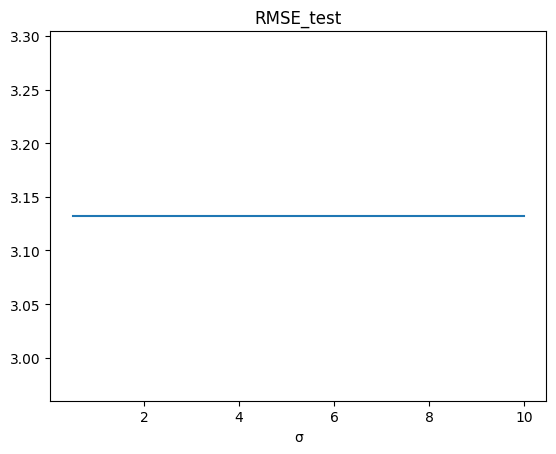

Min of RMSE_test: 3.1322178192467454 for σ = 0.5


In [19]:
plt.plot(spread, RMSE_test)
plt.title('RMSE_test')
plt.xlabel('σ')
plt.show()
print('Min of RMSE_test:', np.min(RMSE_test), 'for σ =', spread[np.argmin(RMSE_test)])

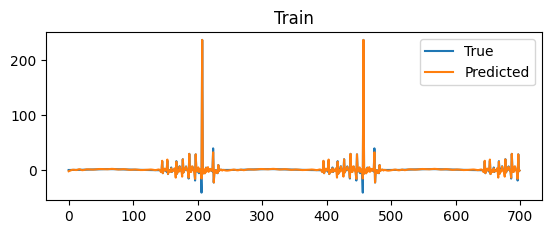

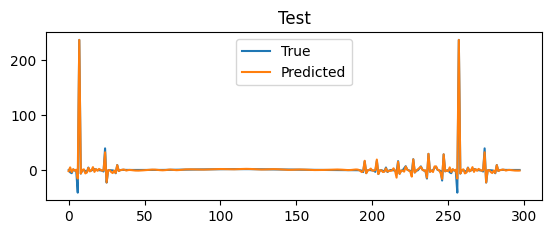

Root mean square error for train: 2.0020119337678244
Root mean square error for test: 2.695497959946468


In [20]:
k = 200
spread = 1
model = RBF(k,spread)
model.fit(X_train, y_train)

y_pred_train = model(X_train)
y_pred_test = model(X_test)

plt.subplot(2,1 ,1)
plt.plot(y_train, label = 'True')
plt.plot(y_pred_train, label = 'Predicted')
plt.title('Train')
plt.legend()
plt.show()

plt.subplot(2,1 ,2)
plt.plot(y_test, label = 'True')
plt.plot(y_pred_test, label = 'Predicted')
plt.title('Test')
plt.legend()
plt.show()
print('Root mean square error for train:',RMSE(y_train, y_pred_train))
print('Root mean square error for test:',RMSE(y_test, y_pred_test))

In [21]:
class RBF_L2(RBF):
    def __init__(self, n_center=10, spread = -1, regular = 0):
        super().__init__(n_center, spread)
        self.regular = regular

    def fit(self, X, y):
        self.centers = np.random.choice(X.shape[0], self.n_center, replace=False)
        self.centers = X[self.centers]

        if self.spread == -1:
            self.spread = mean_distance_centers(self.centers)
        Phi = np.empty((X.shape[0],self.n_center))
        for i, center in enumerate(self.centers):
            g = gussianRBF(X, center, self.spread)
            Phi[:,i] = g
        if self.regular:
            w = np.linalg.inv(Phi.T@Phi+self.regular*np.eye((Phi.T@Phi).shape[0]))@Phi.T @ y
        else:
            w = np.linalg.pinv(Phi) @ y
        self.w = w


In [22]:
k = 500
spread = 1
lambdas = [0.001, 0.01, 0.1, 1, 10]
RMSE_test = []

for l in lambdas:
    model = RBF_L2(k, spread, l)
    model.fit(X_train, y_train)

    y_pred_test = model(X_test)
    RMSE_test.append(RMSE(y_test, y_pred_test))

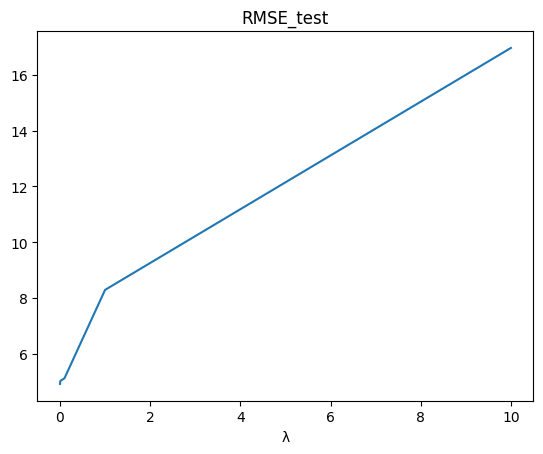

Min of RMSE_test: 4.911635343778568 for λ = 0.001


In [23]:
plt.plot(lambdas, RMSE_test)
plt.title('RMSE_test')
plt.xlabel('λ')
plt.show()
print('Min of RMSE_test:', np.min(RMSE_test), 'for λ =', lambdas[np.argmin(RMSE_test)])

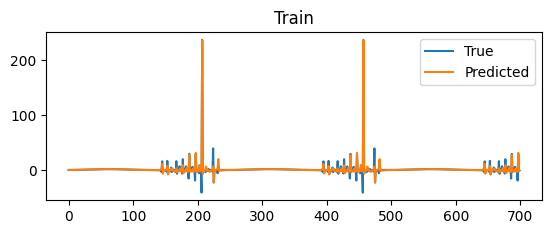

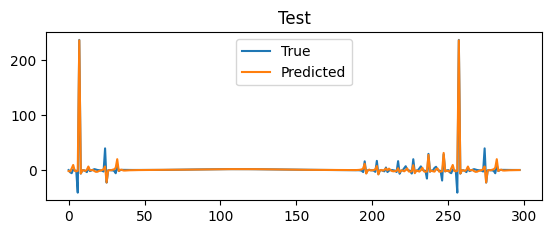

Root mean square error for train: 3.7938234820530767
Root mean square error for test: 5.021534926937046


In [24]:
model_l2 = RBF_L2(600, 1,0.01)
model_l2.fit(X_train, y_train)
y_pred_train = model_l2(X_train)
y_pred_test = model_l2(X_test)

plt.subplot(2,1 ,1)
plt.plot(y_train, label = 'True')
plt.plot(y_pred_train, label = 'Predicted')
plt.title('Train')
plt.legend()
plt.show()

plt.subplot(2,1 ,2)
plt.plot(y_test, label = 'True')
plt.plot(y_pred_test, label = 'Predicted')
plt.title('Test')
plt.legend()
plt.show()
print('Root mean square error for train:',RMSE(y_train, y_pred_train))
print('Root mean square error for test:',RMSE(y_test, y_pred_test))

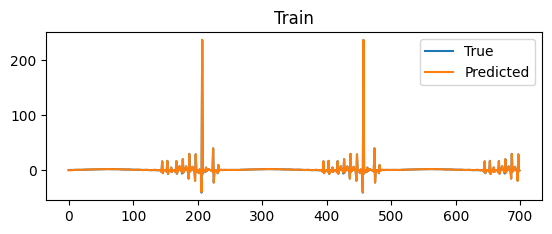

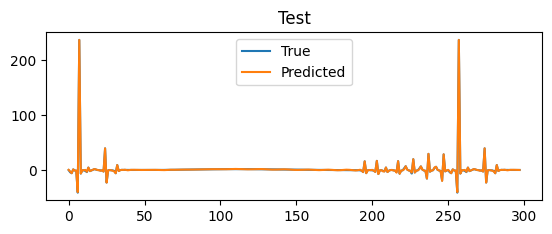

Root mean square error for train: 0.3671709547247876
Root mean square error for test: 0.3889998567710606


In [25]:
model = RBF(500, 1)
model.fit(X_train, y_train)
y_pred_train = model(X_train)
y_pred_test = model(X_test)

plt.subplot(2,1 ,1)
plt.plot(y_train, label = 'True')
plt.plot(y_pred_train, label = 'Predicted')
plt.title('Train')
plt.legend()
plt.show()

plt.subplot(2,1 ,2)
plt.plot(y_test, label = 'True')
plt.plot(y_pred_test, label = 'Predicted')
plt.title('Test')
plt.legend()
plt.show()
print('Root mean square error for train:',RMSE(y_train, y_pred_train))
print('Root mean square error for test:',RMSE(y_test, y_pred_test))

In [26]:
from sklearn.cluster import KMeans

class RBF_kmeans(RBF):
    def __init__(self, n_center=10, spread=1.0, use_kmeans=False):
        super().__init__(n_center, spread)
        self.use_kmeans = use_kmeans

    def fit(self, X, y):

        if self.use_kmeans:
            kmeans = KMeans(n_clusters=self.n_center, n_init=10, random_state=0)
            kmeans.fit(X)
            self.centers = kmeans.cluster_centers_
        else:
            idx = np.random.choice(X.shape[0], self.n_center, replace=False)
            self.centers = X[idx]

        if self.spread == -1:
            self.spread = mean_distance_centers(self.centers)

        Phi = np.empty((X.shape[0], self.n_center))
        for i, c in enumerate(self.centers):
            Phi[:, i] = gussianRBF(X, c, self.spread)



        w = np.linalg.pinv(Phi) @ y
        self.w = w


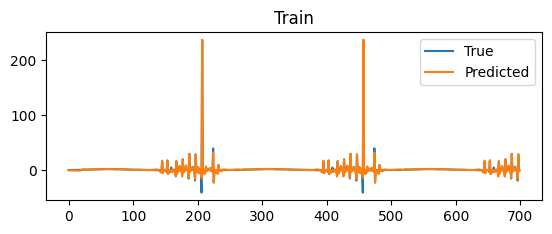

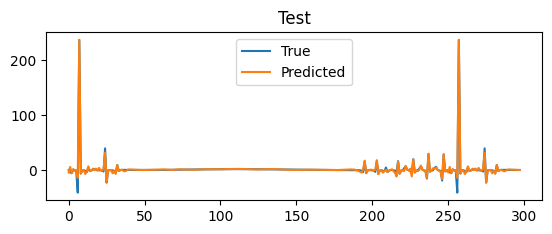

Root mean square error for train: 2.091060778137656
Root mean square error for test: 2.83435484025572


In [27]:
model_l2 = RBF_kmeans(100, -1, use_kmeans=True)
model_l2.fit(X_train, y_train)
y_pred_train = model_l2(X_train)
y_pred_test = model_l2(X_test)

plt.subplot(2,1 ,1)
plt.plot(y_train, label = 'True')
plt.plot(y_pred_train, label = 'Predicted')
plt.title('Train')
plt.legend()
plt.show()

plt.subplot(2,1 ,2)
plt.plot(y_test, label = 'True')
plt.plot(y_pred_test, label = 'Predicted')
plt.title('Test')
plt.legend()
plt.show()

print('Root mean square error for train:',RMSE(y_train, y_pred_train))
print('Root mean square error for test:',RMSE(y_test, y_pred_test))

In [28]:
def nearest_neighbour(centers, p):
    spreads = []
    for i in range(centers.shape[0]):
        distance = []
        for j in range(centers.shape[0]):
            if i != j:
                dist = np.linalg.norm(centers[i] - centers[j])
                distance.append(dist)

        distance.sort()
        distance = distance[:p]
        spreads.append(np.mean(distance))

    return np.array(spreads)

In [29]:
class RBF_using_nearest:
    def __init__(self, n_center=10, use_kmeans=False, p = 2):
        self.n_center = n_center
        self.use_kmeans = use_kmeans
        self.p = p

    def fit(self, X, y):
        if self.use_kmeans:
            kmeans = KMeans(n_clusters=self.n_center, n_init=10, random_state=0)
            kmeans.fit(X)
            self.centers = kmeans.cluster_centers_
        else:
            idx = np.random.choice(X.shape[0], self.n_center, replace=False)
            self.centers = X[idx]

        self.spreads = nearest_neighbour(self.centers, self.p)
        Phi = np.empty((X.shape[0], self.n_center))
        for i, c in enumerate(self.centers):
            Phi[:, i] = gussianRBF(X, c, self.spreads[i])

        w = np.linalg.pinv(Phi) @ y
        self.w = w

    def __call__(self, X):
        X = np.atleast_2d(X)
        N = X.shape[0]

        Phi = np.empty((N, self.n_center))
        for i, c in enumerate(self.centers):
            Phi[:, i] = gussianRBF(X, c, self.spreads[i])

        y_pred = Phi @ self.w
        return y_pred

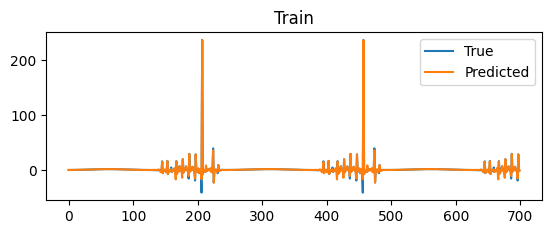

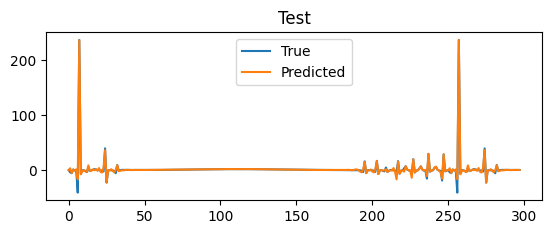

Root mean square error for train: 2.062425126368264
Root mean square error for test: 2.6539044453948386


In [30]:
model = RBF_using_nearest(100, use_kmeans=True)
model.fit(X_train, y_train)
y_pred_train = model(X_train)
y_pred_test = model(X_test)

plt.subplot(2,1 ,1)
plt.plot(y_train, label = 'True')
plt.plot(y_pred_train, label = 'Predicted')
plt.title('Train')
plt.legend()
plt.show()

plt.subplot(2,1 ,2)
plt.plot(y_test, label = 'True')
plt.plot(y_pred_test, label = 'Predicted')
plt.title('Test')
plt.legend()
plt.show()

print('Root mean square error for train:',RMSE(y_train, y_pred_train))
print('Root mean square error for test:',RMSE(y_test, y_pred_test))

In [31]:
class MRAN_Network:
    def __init__(self, e_min = 0.5, epsilon = 1.0, kappa = 0.8, eta=0.05):
        self.centers = []
        self.sigmas = []
        self.weights = []

        self.e_min = e_min
        self.epsilon = epsilon

        self.kappa = kappa
        self.eta = eta

        self.neuron_history = []

    def __call__(self, x):
        if len(self.centers) == 0:
            return 0.0

        output = 0.0
        for i in range(len(self.centers)):
            phi = gussianRBF(x, self.centers[i], self.sigmas[i])
            output += self.weights[i] * phi
        return output

    def get_nearest_center_info(self, x):
        if len(self.centers) == 0:
            return float('inf'), -1

        dists = [np.linalg.norm(np.array(x) - np.array(c)) for c in self.centers]
        min_dist = np.min(dists)
        min_index = np.argmin(dists)
        return min_dist, min_index

    def fit(self, X, y):
        for n in range(len(X)):
            x_n = X[n]
            y_n = y[n]

            y_pred = self.__call__(x_n)
            error = y_n - y_pred  # e_n = y_n - f(x_n)


            dist_to_nearest, nearest_idx = self.get_nearest_center_info(x_n)

            is_novel = dist_to_nearest > self.epsilon
            is_high_error = abs(error) > self.e_min

            neuron_added = False

            if is_novel and is_high_error:
                self.centers.append(x_n)
                self.weights.append(error)

                if len(self.centers) > 1:
                    new_sigma = self.kappa * dist_to_nearest
                else:
                    new_sigma = self.kappa

                self.sigmas.append(new_sigma)
                neuron_added = True

            else:
                if len(self.centers) > 0:
                    for k in range(len(self.centers)):
                        phi_k = gussianRBF(x_n, self.centers[k], self.sigmas[k])
                        self.weights[k] += self.eta * error * phi_k


            self.neuron_history.append(len(self.centers))

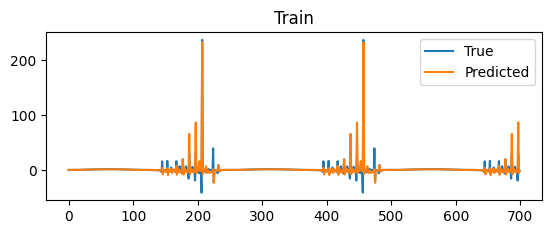

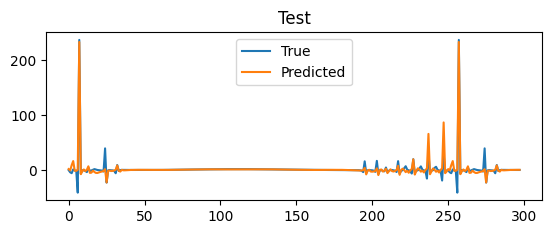

Root mean square error for train: 6.254103232389773
Root mean square error for test: 6.929907226025705
Final Neurons: 25


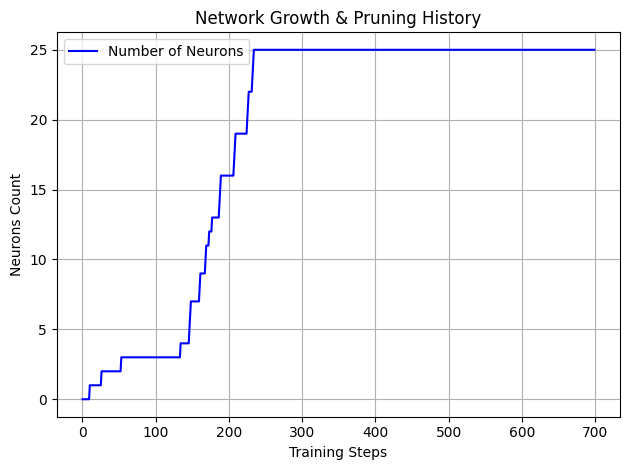

In [32]:
mran = MRAN_Network(e_min = 0.05, epsilon = 0.5)
final_rmse = mran.fit(X_train, y_train)

y_pred_train = [mran(x) for x in X_train]
y_pred_test = [mran(x) for x in X_test]

plt.subplot(2,1 ,1)
plt.plot(y_train, label = 'True')
plt.plot(y_pred_train, label = 'Predicted')
plt.title('Train')
plt.legend()
plt.show()

plt.subplot(2,1 ,2)
plt.plot(y_test, label = 'True')
plt.plot(y_pred_test, label = 'Predicted')
plt.title('Test')
plt.legend()
plt.show()

print('Root mean square error for train:',RMSE(y_train, y_pred_train))
print('Root mean square error for test:',RMSE(y_test, y_pred_test))

print(f"Final Neurons: {len(mran.centers)}")

plt.plot(mran.neuron_history, 'b-', label='Number of Neurons')
plt.title('Network Growth & Pruning History')
plt.ylabel('Neurons Count')
plt.xlabel('Training Steps')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [33]:
class AdaptiveRBF:
    def __init__(self, delta=0.1, e_min = 0.5, epsilon = 1.0, kappa = 0.8, eta=0.05, M_pruning=60):
        self.centers = []
        self.sigmas = []
        self.weights = []
        self.pruning_counters = []

        self.e_min = e_min
        self.epsilon = epsilon

        self.kappa = kappa
        self.eta = eta

        self.delta = delta
        self.M_pruning = M_pruning
        self.neuron_history = []


    def _gaussian_func(self, x, center, sigma):
        dist = np.linalg.norm(np.array(x) - np.array(center))
        return np.exp(- (dist ** 2) / (sigma ** 2))

    def __call__(self, x):
        if len(self.centers) == 0:
            return 0.0

        output = 0.0
        for i in range(len(self.centers)):
            phi = gussianRBF(x, self.centers[i], self.sigmas[i])
            output += self.weights[i] * phi
        return output

    def get_nearest_center_info(self, x):
        if len(self.centers) == 0:
            return float('inf'), -1

        dists = [np.linalg.norm(np.array(x) - np.array(c)) for c in self.centers]
        min_dist = np.min(dists)
        min_index = np.argmin(dists)
        return min_dist, min_index

    def fit(self, X, y):
        squared_errors = []

        for n in range(len(X)):
            x_n = X[n]
            y_n = y[n]

            y_pred = self.__call__(x_n)
            error = y_n - y_pred  # e_n = y_n - f(x_n)
            dist_to_nearest, nearest_idx = self.get_nearest_center_info(x_n)
            is_novel = dist_to_nearest > self.epsilon
            is_high_error = abs(error) > self.delta

            neuron_added = False

            if is_novel and is_high_error:

                self.centers.append(x_n)
                self.weights.append(error)
                if len(self.centers) > 1:
                    new_sigma = self.kappa * dist_to_nearest
                else:
                    new_sigma = self.kappa

                self.sigmas.append(new_sigma)
                self.pruning_counters.append(0)
                neuron_added = True

            else:
                if len(self.centers) > 0:
                    for k in range(len(self.centers)):
                        phi_k = gussianRBF(x_n, self.centers[k], self.sigmas[k])
                        self.weights[k] += self.eta * error * phi_k

            if len(self.centers) > 0:
                self._prune_neurons(x_n)



            self.neuron_history.append(len(self.centers))


    def _prune_neurons(self, x_n):
        outputs = []

        for k in range(len(self.centers)):
            phi = gussianRBF(x_n, self.centers[k], self.sigmas[k])
            out_k = self.weights[k] * phi
            outputs.append(out_k)

        max_output = np.max(np.abs(outputs))

        if max_output == 0: return

        indices_to_remove = []

        for k in range(len(self.centers)):
            r_k = abs(outputs[k]) / max_output

            if r_k < self.delta:
                self.pruning_counters[k] += 1
            else:

                self.pruning_counters[k] = 0


            if self.pruning_counters[k] > self.M_pruning:
                indices_to_remove.append(k)

        for idx in sorted(indices_to_remove, reverse=True):
            del self.centers[idx]
            del self.sigmas[idx]
            del self.weights[idx]
            del self.pruning_counters[idx]




In [34]:
Eps = [0.05, 0.1, 0.15, 0.2, 0.5, 1]
Emin = Eps
hyper = []
RMSE_test = []
for eps in Eps:
    for emin in Emin:
        model = AdaptiveRBF(e_min = emin, epsilon = eps)
        model.fit(X_train, y_train)

        y_pred_test = [model(x) for x in X_test]
        rmse = RMSE(y_test, y_pred_test)
        RMSE_test.append(rmse)
        hyper.append((emin, eps))
        print(f'RMSE for for (emin, ε) ={(emin, eps)}: {rmse}')


RMSE for for (emin, ε) =(0.05, 0.05): 20.17066383089116
RMSE for for (emin, ε) =(0.1, 0.05): 20.17066383089116
RMSE for for (emin, ε) =(0.15, 0.05): 20.17066383089116
RMSE for for (emin, ε) =(0.2, 0.05): 20.17066383089116
RMSE for for (emin, ε) =(0.5, 0.05): 20.17066383089116
RMSE for for (emin, ε) =(1, 0.05): 20.17066383089116
RMSE for for (emin, ε) =(0.05, 0.1): 20.218507767499336
RMSE for for (emin, ε) =(0.1, 0.1): 20.218507767499336
RMSE for for (emin, ε) =(0.15, 0.1): 20.218507767499336
RMSE for for (emin, ε) =(0.2, 0.1): 20.218507767499336
RMSE for for (emin, ε) =(0.5, 0.1): 20.218507767499336
RMSE for for (emin, ε) =(1, 0.1): 20.218507767499336
RMSE for for (emin, ε) =(0.05, 0.15): 20.26023496004108
RMSE for for (emin, ε) =(0.1, 0.15): 20.26023496004108
RMSE for for (emin, ε) =(0.15, 0.15): 20.26023496004108
RMSE for for (emin, ε) =(0.2, 0.15): 20.26023496004108
RMSE for for (emin, ε) =(0.5, 0.15): 20.26023496004108
RMSE for for (emin, ε) =(1, 0.15): 20.26023496004108
RMSE for f

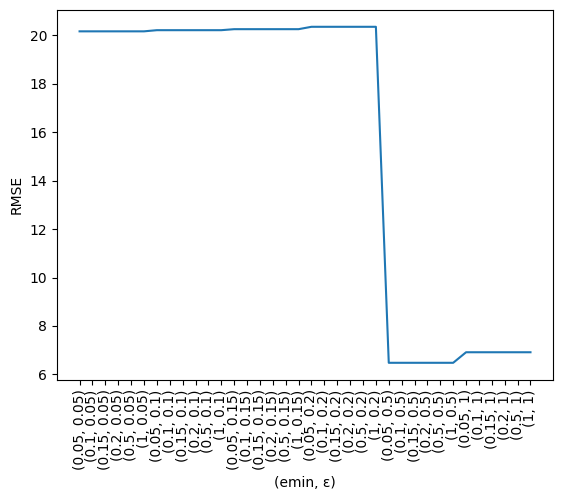

Min of RMSE_test: 6.478832812089181 for (emin, ε) = (0.05, 0.5)


In [35]:
hyper_str = [str(h) for h in hyper]
plt.plot(hyper_str, RMSE_test, label = 'RMSE')
plt.xlabel('(emin, ε)')
plt.ylabel('RMSE')
plt.xticks(rotation = 90)
plt.show()

print('Min of RMSE_test:', np.min(RMSE_test), 'for (emin, ε) =', hyper[np.argmin(RMSE_test)])

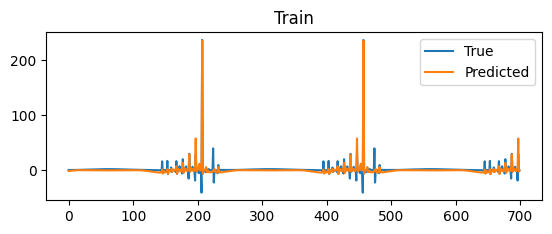

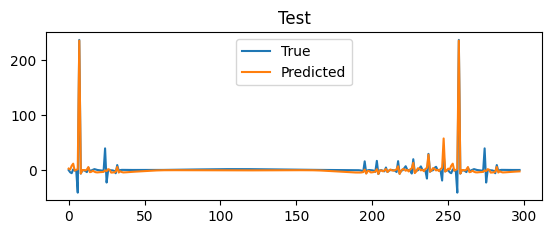

Root mean square error for train: 5.23031952813634
Root mean square error for test: 6.478832812089181
Final Neurons: 16


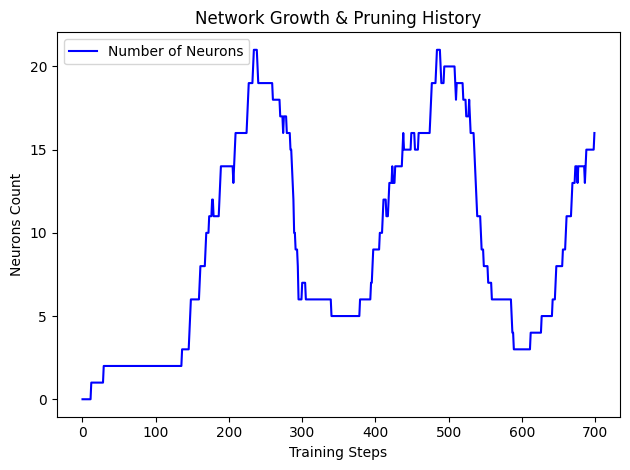

In [36]:
RBF_adap = AdaptiveRBF(e_min = 0.05, epsilon = 0.5)
final_rmse = RBF_adap.fit(X_train, y_train)

y_pred_train = [RBF_adap(x) for x in X_train]
y_pred_test = [RBF_adap(x) for x in X_test]

plt.subplot(2,1 ,1)
plt.plot(y_train, label = 'True')
plt.plot(y_pred_train, label = 'Predicted')
plt.title('Train')
plt.legend()
plt.show()

plt.subplot(2,1 ,2)
plt.plot(y_test, label = 'True')
plt.plot(y_pred_test, label = 'Predicted')
plt.title('Test')
plt.legend()
plt.show()

print('Root mean square error for train:',RMSE(y_train, y_pred_train))
print('Root mean square error for test:',RMSE(y_test, y_pred_test))

print(f"Final Neurons: {len(RBF_adap.centers)}")

plt.plot(RBF_adap.neuron_history, 'b-', label='Number of Neurons')
plt.title('Network Growth & Pruning History')
plt.ylabel('Neurons Count')
plt.xlabel('Training Steps')
plt.legend()

plt.tight_layout()
plt.show()